In [2]:
import numpy as np

import arviz as az

from matplotlib import pyplot as plt

from cartopy import crs as ccrs

from pandas import read_csv

from pymagglobal.utils import i2lm_l

from scipy.stats import t, norm

from common import z_at, data, n_coeffs, rawData, lmax

In [3]:
prefix = 'arch'
# prefix = 'radio_afm9k'
# prefix = 'radio_pfm_afm9k'
# prefix = 'radio_bimodal'
# prefix = 'radio_bimodal_longterm_1000'
idata_fname = f'../out/{prefix}_result.nc'
summary_fname = f'../out/{prefix}_summary.csv'
coeff_fname = f'../out/{prefix}_ensemble.npz'

In [4]:
iData = az.from_netcdf(idata_fname)

summary = read_csv(summary_fname)
summary.rename(columns={'Unnamed: 0': 'Name'}, inplace=True)

with np.load(coeff_fname) as fh:
    knots = fh['knots']
    coeffs = fh['coeffs']

FileNotFoundError: [Errno 2] No such file or directory: '../out/arch_ensemble.npz'

In [7]:
ts = z_at[None, None, 3] - \
    np.array(iData.posterior['t_cent']) \
    * np.sqrt(data.errs_T_raw)[None, None, :]

In [8]:
iData

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [7]:
summary['ess_tail'].mean(), summary['ess_tail'].std()

(1220.3286851300634, 306.6395975981372)

In [12]:
summary[summary['Name'] == 'tL_cent']

,Name,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


In [24]:
cnt = 0

t_inds = []
names = []
for it in summary['Name'][
    np.argwhere(summary['r_hat'].values > 1.1).flatten()
]:
    if "t_cent" in it:
        t_inds.append(int(it.split('[')[1].strip(']')))
    names.append(it)
    cnt += 1


In [25]:
print(
    "The maximal treedepth was "
    f"{np.max(np.array(iData.sample_stats['tree_depth']))}."
)
print(
    f"The chains had {np.sum(np.array(iData.sample_stats['diverging']))} "
    "divergences."
)
print(
    f"There were {cnt} random variables with rhat > 1.1."
)

The maximal treedepth was 10.
The chains had 0 divergences.
There were 61 random variables with rhat > 1.1.


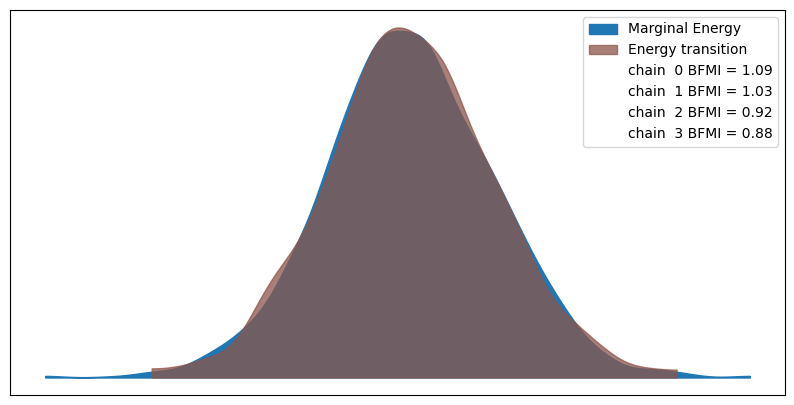

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

az.plot_energy(iData, ax=ax);

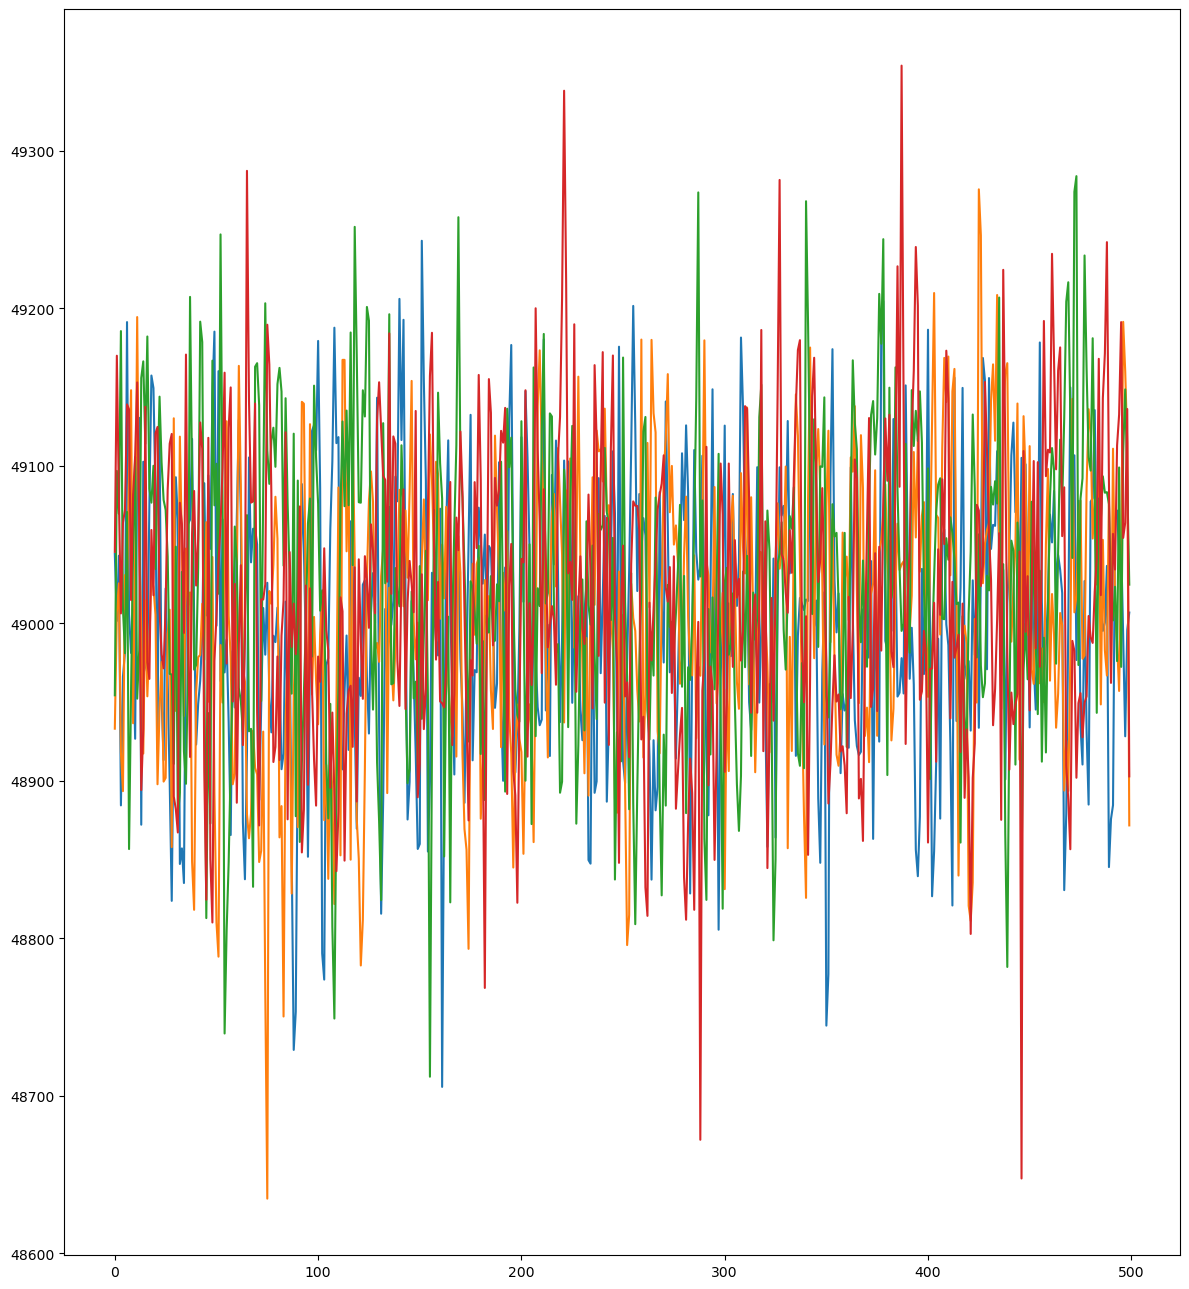

In [16]:
lp = np.array(iData.sample_stats['lp'])
n_chains = lp.shape[0]

fig, ax = plt.subplots(1, 1, figsize=(12, 1+n_chains*3))

for it in range(n_chains):
    ax.plot(
        np.arange(lp.shape[1]),
        lp[it],
    )

fig.tight_layout(w_pad=1.3)

In [11]:
rD = np.array(iData.posterior['rD'])
rI = np.array(iData.posterior['rI'])
rF = np.array(iData.posterior['rF'])
nus = np.array(iData.posterior['nu'])
# print(np.mean(nus, axis=1))
# nus = 3*np.ones((2, 10, 5))


In [12]:
sf = np.array(iData.posterior['s_fac'])
sf.mean(axis=1)

array([[-1.47455447,  0.08047853, -0.79279414],
       [-1.47110012,  0.09064306, -0.77904361],
       [-1.5114156 ,  0.0339426 , -0.82709075],
       [-1.49402451,  0.04837958, -0.81001083]])

In [13]:
nus.mean(axis=1)

array([[3.35333874, 2.1044232 , 1.41237931],
       [3.33016245, 2.10039176, 1.42221843],
       [3.370011  , 2.10902782, 1.41915994],
       [3.36810493, 2.10050356, 1.41029018]])

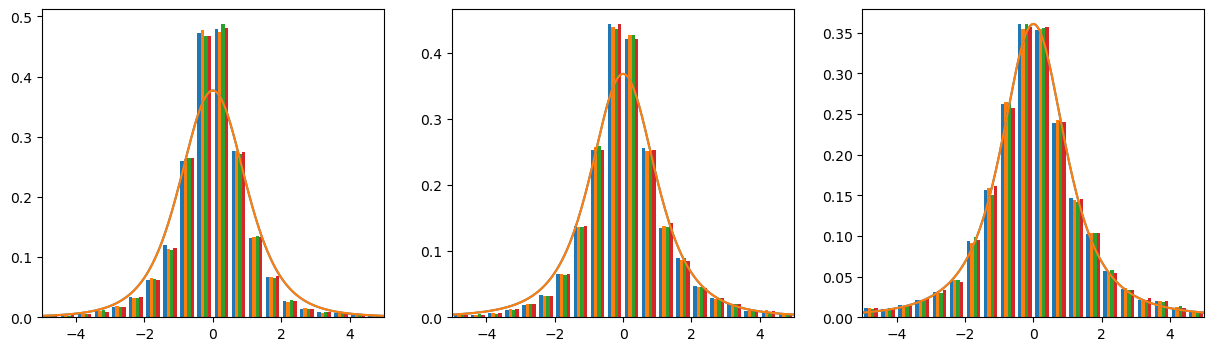

In [14]:
rs = [
    rD,
    rI,
    rF,
]

fig, axs = plt.subplots(1, len(rs), figsize=(15, 4))

# for it in range(len(rs)):
for it in range(3):
    _, bins, _ = axs[it].hist(
        np.mean(rs[it], axis=1).T,
        bins=np.linspace(-5, 5, 21),
        density=True,
    )
    arr = np.linspace(
        np.min(bins),
        np.max(bins),
        401,
    )
    axs[it].plot(
        arr,
        t.pdf(arr, df=1+np.mean(nus[0, :, it])),
        color='C0',
    )
    axs[it].plot(
        arr,
        t.pdf(arr, df=1+np.mean(nus[1, :, it])),
        color='C1',
    )
    axs[it].set_xlim(-5, 5)

In [15]:
rNH = np.array(iData.posterior['rNH'])
rSH = np.array(iData.posterior['rSH'])
rGL = np.array(iData.posterior['rC14'])

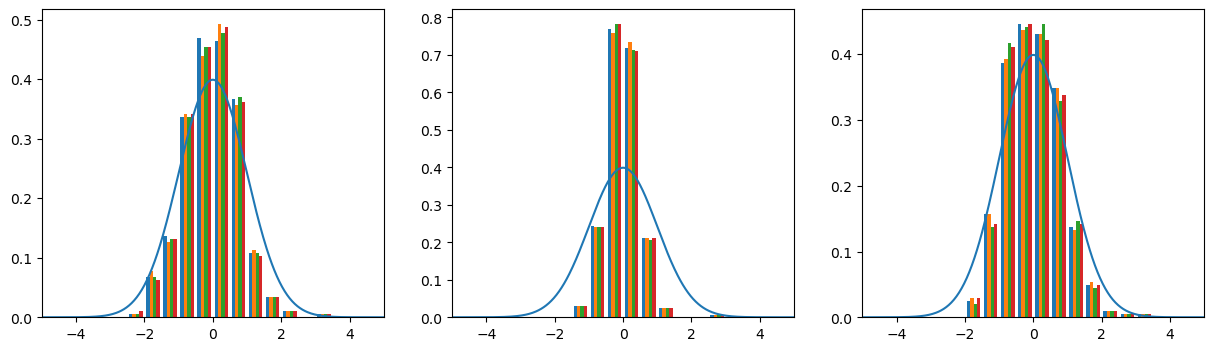

In [16]:
rs = [
    rNH,
    rSH,
    rGL,
]

fig, axs = plt.subplots(1, len(rs), figsize=(15, 4))

# for it in range(len(rs)):
for it in range(3):
    _, bins, _ = axs[it].hist(
        np.mean(rs[it], axis=1).T,
        bins=np.linspace(-5, 5, 21),
        density=True,
    )
    arr = np.linspace(
        np.min(bins),
        np.max(bins),
        401,
    )
    axs[it].plot(
        arr,
        norm.pdf(arr),
        color='C0',
    )
    axs[it].set_xlim(-5, 5)

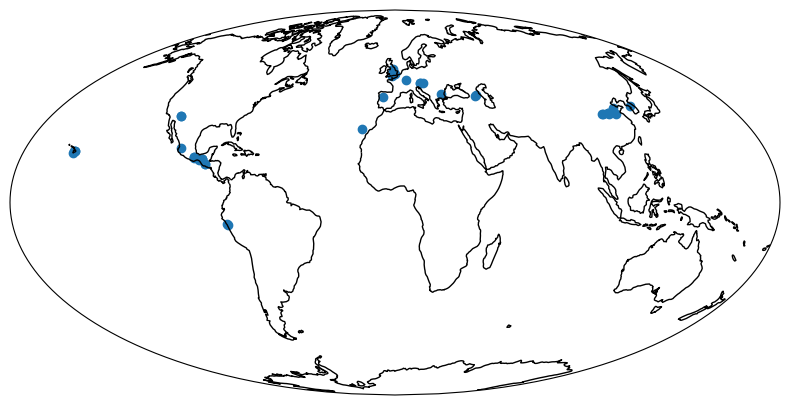

In [17]:
locs = data.inputs[:, t_inds]
# locs[1][np.argwhere(locs[1] > 180)] -= 360
proj = ccrs.Mollweide()
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': proj}, figsize=(10, 5))

ax.scatter(
    locs[1],
    90-locs[0],
    transform=ccrs.PlateCarree(),
)
ax.set_global()
ax.coastlines()

In [21]:
len(t_inds)

40

In [19]:
n_plots = len(t_inds)

if n_plots <= 20:
    if n_plots <= 3:
        n_row = 1
        n_col = n_plots
    elif n_plots <= 6:
        n_row = 2
        n_col = n_plots // 3 + 1
    elif n_plots <= 8:
        n_row = 2
        n_col = 4
    elif n_plots == 9:
        n_row = 2
        n_col = 4
    else:
        n_row = int(np.ceil(n_plots / 4))
        n_col = 4

    fig, axs = plt.subplots(
        n_row, n_col,
        figsize=(10, 1 + 3*n_row),
    )

    for idx in range(axs.size - n_plots):
        axs[n_row-1, -(idx + 1)].axis('off')

    for it, ind in enumerate(t_inds):
        i, j = np.unravel_index(it, axs.shape)

        vals, bins, _ = axs[i, j].hist(
            ts[:, :, ind].T,
            bins=50,
            density=True,
        )
        axs[i, j].set_yticks([])
        axs[i, j].text(
            bins[0], 0.95*np.max(vals),
            f'{z_at[3, ind]:.0f}',
        )
        axs[i, j].text(
            bins[0], 0.88*np.max(vals),
            f'{np.sqrt(data.errs_T_raw)[ind]:.0f}',
        )


In [20]:
names

['rD[531]',
 'rD[566]',
 'rD[607]',
 'rD[2290]',
 'rD[2291]',
 'rD[2681]',
 'rD[2691]',
 'rD[2781]',
 'rD[2938]',
 'rD[4166]',
 'rD[4186]',
 'rD[4192]',
 'rF[1235]',
 'rF[1393]',
 'rI[756]',
 'rI[1052]',
 'rI[2331]',
 'rI[2529]',
 'rI[3602]',
 'rI[4771]',
 'rI[4861]',
 't_cent[733]',
 't_cent[1146]',
 't_cent[1169]',
 't_cent[1328]',
 't_cent[1473]',
 't_cent[1689]',
 't_cent[1815]',
 't_cent[1816]',
 't_cent[1865]',
 't_cent[1960]',
 't_cent[1992]',
 't_cent[2299]',
 't_cent[2451]',
 't_cent[2452]',
 't_cent[2471]',
 't_cent[2662]',
 't_cent[2666]',
 't_cent[3188]',
 't_cent[3912]',
 't_cent[4088]',
 't_cent[4232]',
 't_cent[4275]',
 't_cent[4301]',
 't_cent[4486]',
 't_cent[4623]',
 't_cent[4824]',
 't_cent[4825]',
 't_cent[4892]',
 't_cent[4893]',
 't_cent[5373]',
 't_cent[5385]',
 't_cent[5515]',
 't_cent[5753]',
 't_cent[6236]',
 't_cent[6303]',
 't_cent[7922]',
 't_cent[7949]',
 't_cent[7951]',
 't_cent[7957]',
 't_cent[8038]']

In [20]:
from paleokalmag.data_handling import Data

In [21]:
dat = Data(rawData)

In [22]:
tR = iData.posterior['tR'].values.reshape(-1)
tL = 200 * iData.posterior['tL_cent'].values.reshape(-1) + 150

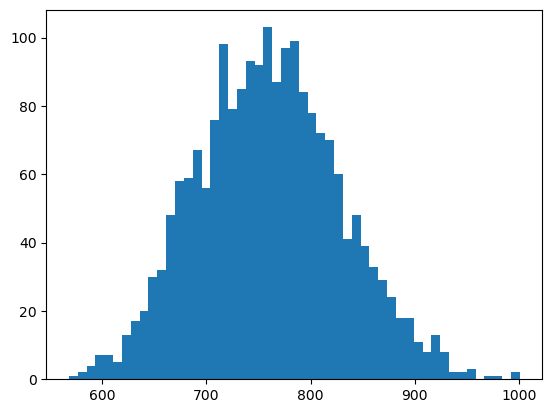

In [23]:
plt.hist(tR, bins=51);

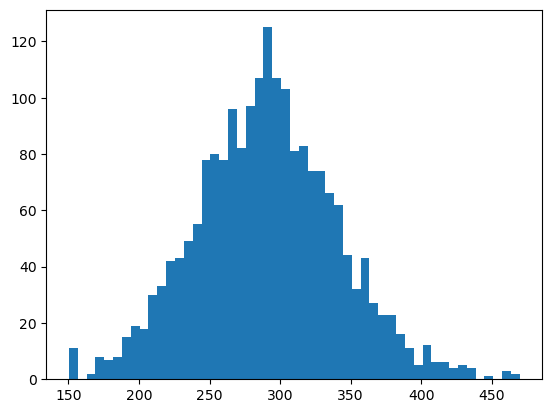

In [24]:
plt.hist(tL, bins=51);

In [25]:
kappa = iData.posterior['kappa'].values.reshape(-1)

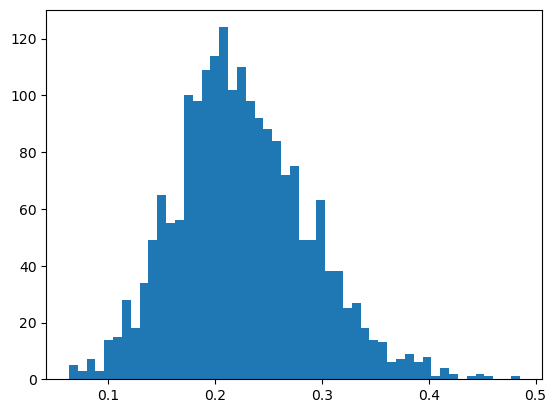

In [26]:
plt.hist(kappa, bins=51);

In [27]:
solarmod = iData.posterior['sm_at_knots'].values

In [28]:
solarmod = solarmod.reshape(-1, 411)

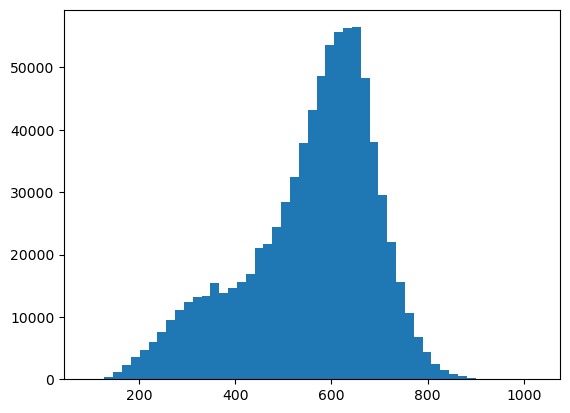

In [29]:
plt.hist(
    solarmod.flatten(),
    bins=51,
);

In [30]:
print(f"kappa: {kappa.mean()}±{kappa.std()}")
print(f"tL: {tL.mean()}±{tL.std()}")
print(f"tR: {tR.mean()}±{tR.std()}")

kappa: 0.22583408306037617±0.062387718626369104
tL: 290.70650053004204±50.23434797155385
tR: 760.0236763563514±68.7266995565438
